### Reading-in the data

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(9,5.5)})
sns.set_style("whitegrid")
sns.set_context("talk")

In [63]:
def read_clean_data(filename):
    df = pd.read_csv(filename)[['title','artist','year','bpm', 'nrgy', 'dnce', 'dB','live', 'val', 'dur','acous', 'spch','pop']]
    df = df.rename({'bpm':'tempo','nrgy':'energy','dnce':'danceability','dB':'loudness','live':'liveness',
                  'val':'valence','dur':'duration','acous':'acousticness','spch':'speechiness','pop':'popularity'},
                 axis = 1)
    df['decade'] = filename[2:4] + 's'
    df = df[~df["year"].between(1991,1999)]
    return df

In [64]:
filenames = ['1980.csv','2010.csv']

df = pd.concat([read_clean_data(i) for i in filenames]).reset_index()
X = df.iloc[:,4:len(df.columns)-1]
y = df["decade"].values

In [65]:
# Descriptive statistics
print(df["decade"].value_counts()) # balanced classes

df[df["decade"]=="80s"].describe().T.drop("count",axis=1)

df[df["decade"]=="10s"].describe().T.drop("count",axis=1)

10s    100
80s     96
Name: decade, dtype: int64


,mean,std,min,25%,50%,75%,max
index,49.50,29.011492,0.0,24.75,49.5,74.25,99.0
year,2015.91,2.314186,2010.0,2015.00,2017.0,2017.00,2019.0
tempo,118.72,22.389157,75.0,101.50,120.0,134.00,186.0
energy,67.98,16.261114,17.0,56.75,68.0,80.00,95.0
danceability,65.37,11.880427,21.0,58.00,67.0,74.00,91.0
loudness,-5.49,2.002498,-13.0,-6.00,-5.0,-4.00,-2.0
liveness,17.93,13.822288,3.0,9.75,13.0,25.00,82.0
valence,46.35,20.945034,9.0,29.00,47.0,61.00,97.0
duration,209.17,24.080276,157.0,194.00,209.0,222.00,306.0
acousticness,14.71,17.911846,0.0,3.75,9.0,19.00,84.0


In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X,y,np.arange(len(y)),test_size = 0.20, random_state = 0)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, KFold, PredefinedSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

cv = KFold(5)

indices = np.zeros_like(y_train)
indices[int(len(y_train)*0.3):] = -1
validate = PredefinedSplit(indices)

In [68]:
def fit_model(X_train, y_train, model, cv, param_grid = {}, output=True):
    grid_search = GridSearchCV(model,param_grid=param_grid,cv=cv)
    grid_search.fit(X_train,y_train)
    # results for different parameter values
    if output:
        results_df = pd.DataFrame(grid_search.cv_results_)
        results_df = results_df.iloc[:,(results_df.columns.str.contains("param_")) |  (results_df.columns == "mean_test_score")]
        print(results_df)
    results_df.round(3).to_csv("cv_results.csv",index=False)
    return grid_search

### Naive Bayes

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector,RFE
nb = GaussianNB()

nb_pipe = Pipeline([
   ('select', SequentialFeatureSelector(nb,direction="backward")),
   ('model', nb)])

param_grid_nb = {
    'select__n_features_to_select': [0.2,0.4,0.6,0.8,1.0]}

nb_best = fit_model(X_train,y_train,nb_pipe,cv,param_grid_nb).best_estimator_

nb_best.get_params()

  param_select__n_features_to_select  mean_test_score
0                                0.2         0.813911
1                                0.4         0.852419
2                                0.6         0.865323
3                                0.8         0.858871
4                                1.0         0.865323


{'memory': None,
 'steps': [('select',
   SequentialFeatureSelector(direction='backward', estimator=GaussianNB(),
                             n_features_to_select=0.6)),
  ('model', GaussianNB())],
 'verbose': False,
 'select': SequentialFeatureSelector(direction='backward', estimator=GaussianNB(),
                           n_features_to_select=0.6),
 'model': GaussianNB(),
 'select__cv': 5,
 'select__direction': 'backward',
 'select__estimator__priors': None,
 'select__estimator__var_smoothing': 1e-09,
 'select__estimator': GaussianNB(),
 'select__n_features_to_select': 0.6,
 'select__n_jobs': None,
 'select__scoring': None,
 'model__priors': None,
 'model__var_smoothing': 1e-09}

In [70]:
# dropped columns
used_columns = nb_best["select"].get_support(indices=True)
X.drop(columns=X.columns[used_columns])

,tempo,energy,liveness,valence
0,123,89,29,80
1,93,37,5,73
2,110,53,16,75
3,110,59,9,83
4,119,82,9,87
5,139,83,7,77
6,123,96,34,81
7,112,80,10,54
8,177,90,14,77
9,108,58,18,94


In [101]:
nb_pca_pipe = Pipeline([
   ('select', PCA()),
   ('model', nb)])

param_grid_pca_nb = {
    'select__n_components': [2,4,6,8,10]}

nb_pca_best = fit_model(X_train,y_train,nb_pca_pipe,cv,param_grid_pca_nb).best_estimator_

nb_pca_best.get_params()

  param_select__n_components  mean_test_score
0                          2         0.833065
1                          4         0.839315
2                          6         0.820363
3                          8         0.833468
4                         10         0.827016


{'memory': None,
 'steps': [('select', PCA(n_components=4)), ('model', GaussianNB())],
 'verbose': False,
 'select': PCA(n_components=4),
 'model': GaussianNB(),
 'select__copy': True,
 'select__iterated_power': 'auto',
 'select__n_components': 4,
 'select__random_state': None,
 'select__svd_solver': 'auto',
 'select__tol': 0.0,
 'select__whiten': False,
 'model__priors': None,
 'model__var_smoothing': 1e-09}

### Decision Tree

In [94]:
dt = DecisionTreeClassifier(random_state=100)

dt_pipe = Pipeline([
   ('select', RFE(dt)),
   ('model', dt)])


param_grid_dt = {
    'select__n_features_to_select': [0.6,0.8,1.0],
    "model__max_depth":[4,5,6],"model__min_samples_split":[2,5,10,15]}

dt_best = fit_model(X_train,y_train,dt_pipe,cv,param_grid_dt).best_estimator_

dt_best.get_params()

   param_model__max_depth param_model__min_samples_split  \
0                       4                              2   
1                       4                              2   
2                       4                              2   
3                       4                              5   
4                       4                              5   
5                       4                              5   
6                       4                             10   
7                       4                             10   
8                       4                             10   
9                       4                             15   
10                      4                             15   
11                      4                             15   
12                      5                              2   
13                      5                              2   
14                      5                              2   
15                      5               

{'memory': None,
 'steps': [('select',
   RFE(estimator=DecisionTreeClassifier(random_state=100),
       n_features_to_select=1.0)),
  ('model', DecisionTreeClassifier(max_depth=5, random_state=100))],
 'verbose': False,
 'select': RFE(estimator=DecisionTreeClassifier(random_state=100),
     n_features_to_select=1.0),
 'model': DecisionTreeClassifier(max_depth=5, random_state=100),
 'select__estimator__ccp_alpha': 0.0,
 'select__estimator__class_weight': None,
 'select__estimator__criterion': 'gini',
 'select__estimator__max_depth': None,
 'select__estimator__max_features': None,
 'select__estimator__max_leaf_nodes': None,
 'select__estimator__min_impurity_decrease': 0.0,
 'select__estimator__min_samples_leaf': 1,
 'select__estimator__min_samples_split': 2,
 'select__estimator__min_weight_fraction_leaf': 0.0,
 'select__estimator__random_state': 100,
 'select__estimator__splitter': 'best',
 'select__estimator': DecisionTreeClassifier(random_state=100),
 'select__importance_getter': 'aut

In [100]:
# dropped columns
used_columns = dt_best["select"].get_support(indices=True)
X.drop(columns=X.columns[used_columns])

""
0
1
2
3
4
5
6
7
8
9


In [72]:
dt_pca_pipe = Pipeline([
   ('select', PCA()),
   ('model', dt)])


param_grid_pca_dt = {
    'select__n_components': [4,6,8,10],
    "model__max_depth":[4,5,6],"model__min_samples_split":[2,5,10,15]}

dt_pca_best = fit_model(X_train,y_train,dt_pca_pipe,cv,param_grid_pca_dt).best_estimator_

dt_pca_best.get_params()

   param_model__max_depth param_model__min_samples_split  \
0                       4                              2   
1                       4                              2   
2                       4                              2   
3                       4                              2   
4                       4                              5   
5                       4                              5   
6                       4                              5   
7                       4                              5   
8                       4                             10   
9                       4                             10   
10                      4                             10   
11                      4                             10   
12                      4                             15   
13                      4                             15   
14                      4                             15   
15                      4               

{'memory': None,
 'steps': [('select', PCA(n_components=4)),
  ('model', DecisionTreeClassifier(max_depth=5, random_state=100))],
 'verbose': False,
 'select': PCA(n_components=4),
 'model': DecisionTreeClassifier(max_depth=5, random_state=100),
 'select__copy': True,
 'select__iterated_power': 'auto',
 'select__n_components': 4,
 'select__random_state': None,
 'select__svd_solver': 'auto',
 'select__tol': 0.0,
 'select__whiten': False,
 'model__ccp_alpha': 0.0,
 'model__class_weight': None,
 'model__criterion': 'gini',
 'model__max_depth': 5,
 'model__max_features': None,
 'model__max_leaf_nodes': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__min_weight_fraction_leaf': 0.0,
 'model__random_state': 100,
 'model__splitter': 'best'}

### Random forest

In [83]:
pd.set_option('display.max_rows', 1000)

rf = RandomForestClassifier(random_state=100)

rf_pipe = Pipeline([
   ('select', RFE(rf)),
   ('model', rf)])

param_grid_rf= {
              'select__n_features_to_select': [0.8,0.9,1.0],
              "model__max_features":[2,3,4],
              "model__min_samples_split":[2,5,10],
              "model__n_estimators":[25,50,100]}


rf_best = fit_model(X_train,y_train,rf_pipe,cv,param_grid_rf).best_estimator_

rf_best.get_params()

   param_model__max_features param_model__min_samples_split  \
0                          2                              2   
1                          2                              2   
2                          2                              2   
3                          2                              2   
4                          2                              2   
5                          2                              2   
6                          2                              2   
7                          2                              2   
8                          2                              2   
9                          2                              5   
10                         2                              5   
11                         2                              5   
12                         2                              5   
13                         2                              5   
14                         2                           

{'memory': None,
 'steps': [('select',
   RFE(estimator=RandomForestClassifier(random_state=100),
       n_features_to_select=1.0)),
  ('model', RandomForestClassifier(max_features=2, random_state=100))],
 'verbose': False,
 'select': RFE(estimator=RandomForestClassifier(random_state=100),
     n_features_to_select=1.0),
 'model': RandomForestClassifier(max_features=2, random_state=100),
 'select__estimator__bootstrap': True,
 'select__estimator__ccp_alpha': 0.0,
 'select__estimator__class_weight': None,
 'select__estimator__criterion': 'gini',
 'select__estimator__max_depth': None,
 'select__estimator__max_features': 'auto',
 'select__estimator__max_leaf_nodes': None,
 'select__estimator__max_samples': None,
 'select__estimator__min_impurity_decrease': 0.0,
 'select__estimator__min_samples_leaf': 1,
 'select__estimator__min_samples_split': 2,
 'select__estimator__min_weight_fraction_leaf': 0.0,
 'select__estimator__n_estimators': 100,
 'select__estimator__n_jobs': None,
 'select__esti

In [84]:
# dropped columns
used_columns = rf_best["select"].get_support(indices=True)
X.drop(columns=X.columns[used_columns])

""
0
1
2
3
4
5
6
7
8
9


In [85]:
rf_pca_pipe = Pipeline([
   ('select', PCA()),
   ('model', rf)])

param_grid_pca_rf= {
              'select__n_components': [4,6,8,10],
              "model__max_features":[2,3,4],
              "model__min_samples_split":[2,5,10],
              "model__n_estimators":[25,50,100]}


rf_pca_best = fit_model(X_train,y_train,rf_pca_pipe,cv,param_grid_pca_rf).best_estimator_

rf_pca_best.get_params()

    param_model__max_features param_model__min_samples_split  \
0                           2                              2   
1                           2                              2   
2                           2                              2   
3                           2                              2   
4                           2                              2   
5                           2                              2   
6                           2                              2   
7                           2                              2   
8                           2                              2   
9                           2                              2   
10                          2                              2   
11                          2                              2   
12                          2                              5   
13                          2                              5   
14                          2           

{'memory': None,
 'steps': [('select', PCA(n_components=8)),
  ('model',
   RandomForestClassifier(max_features=4, min_samples_split=10, n_estimators=50,
                          random_state=100))],
 'verbose': False,
 'select': PCA(n_components=8),
 'model': RandomForestClassifier(max_features=4, min_samples_split=10, n_estimators=50,
                        random_state=100),
 'select__copy': True,
 'select__iterated_power': 'auto',
 'select__n_components': 8,
 'select__random_state': None,
 'select__svd_solver': 'auto',
 'select__tol': 0.0,
 'select__whiten': False,
 'model__bootstrap': True,
 'model__ccp_alpha': 0.0,
 'model__class_weight': None,
 'model__criterion': 'gini',
 'model__max_depth': None,
 'model__max_features': 4,
 'model__max_leaf_nodes': None,
 'model__max_samples': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 10,
 'model__min_weight_fraction_leaf': 0.0,
 'model__n_estimators': 50,
 'model__n_jobs': None,


### Model comparison

In [86]:
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score

In [87]:
def cross_validate_ROC_AUC(X_train,y_train,models,cv):
    
    fig, ax = plt.subplots()
    fig2, ax2 = plt.subplots()
    x = 0
    
    for i,j in zip(models,names):
        print(j)
        
        y_proba = cross_val_predict(i,X_train,y_train,method="predict_proba",cv=cv)
        fpr, tpr, _ = roc_curve(y_train, y_proba[:,1],pos_label="80s")
        auc = round(roc_auc_score(y_train, y_proba[:,1]),2)
        ax.plot(fpr, tpr, label=j + " (" + str(i["model"].n_features_in_) + " požymių) " + "AUC="+str(auc))
        
        y_pred = cross_val_predict(i,X_train,y_train,cv=cv) 
        cr = classification_report(y_train,y_pred,output_dict=True)
        cr = pd.DataFrame(cr).transpose()
        print(cr)
        
        
        scores = cross_validate(i,X_train,y_train,cv=cv)["test_score"]
        mean = np.mean(scores)
        sd = np.sqrt(np.var(scores))
        ax2.errorbar(x, mean, yerr=sd,fmt="o",label=j,markersize=12)
        x = x + 1 
        
        # this is to convert to a 'writable' format
        cr = cr.reset_index()
        cr = cr.iloc[0:2,:4]
        cr["accuracy"] = accuracy_score(y_train,y_pred)
        cr.columns.values[0] = "klasė"
        cr.insert(0,"modelis",j)
        cr.columns = pd.Series(cr.columns).str.title()
        cr.round(2).to_csv("cross_validate_"+ j + ".csv",index=False)
        
        print("\n")
        
    ax.set_title("Kryžminės validacijos ROC")
    ax.legend()
    ax2.set_title("Kryžminės validacijos tikslumas (su standartiniu nuokrypiu)")
    ax2.axes.get_xaxis().set_ticks([])
    ax2.legend()

In [88]:
def validate_ROC_AUC(X_train,y_train,models,cv):  
    
    fig, ax = plt.subplots()
    
    for i,j in zip(models,names):
        print(j)
        
        split = list(cv.split())
        train_indices, validate_indices = split[0]
        X_validate = X_train[validate_indices]
        y_validate = y_train[validate_indices]
        X_train_small = X_train[train_indices]
        y_train_small = y_train[train_indices]
        
        i.fit(X_train_small,y_train_small)
        
        y_proba = i.predict_proba(X_validate)
        fpr, tpr, _ = roc_curve(y_validate, y_proba[:,1],pos_label="80s")
        auc = round(roc_auc_score(y_validate, y_proba[:,1]),2)
        ax.plot(fpr, tpr, label=j+ " (" + str(i["model"].n_features_in_) + " požymių) " + " AUC="+str(auc))
        
        y_pred = i.predict(X_validate)
        cr = classification_report(y_validate,y_pred,output_dict=True)
        cr = pd.DataFrame(cr).transpose()
        print(cr)
        
        
        # this is to convert to a 'writable' format
        cr = cr.reset_index()
        cr = cr.iloc[0:2,:4]
        cr["accuracy"] = accuracy_score(y_validate,y_pred)
        cr.columns.values[0] = "klasė"
        cr.insert(0,"modelis",j)
        cr.columns = pd.Series(cr.columns).str.title()
        cr.round(2).to_csv("validate_"+ j + ".csv",index=False)
        
        
        print("\n")
    ax.set_title("Validacijos aibės ROC")
    ax.legend()

In [89]:
models = [nb_best,dt_best,rf_best]
names = ["Naivus Bajeso","Sprendimų medis","Atsitiktinis miškas"]

Naivus Bajeso
              precision    recall  f1-score     support
10s            0.847059  0.900000  0.872727   80.000000
80s            0.887324  0.828947  0.857143   76.000000
accuracy       0.865385  0.865385  0.865385    0.865385
macro avg      0.867191  0.864474  0.864935  156.000000
weighted avg   0.866675  0.865385  0.865135  156.000000


Sprendimų medis
              precision    recall  f1-score     support
10s            0.852273  0.937500  0.892857   80.000000
80s            0.926471  0.828947  0.875000   76.000000
accuracy       0.884615  0.884615  0.884615    0.884615
macro avg      0.889372  0.883224  0.883929  156.000000
weighted avg   0.888420  0.884615  0.884158  156.000000


Atsitiktinis miškas
              precision    recall  f1-score     support
10s            0.858824  0.912500  0.884848   80.000000
80s            0.901408  0.842105  0.870748   76.000000
accuracy       0.878205  0.878205  0.878205    0.878205
macro avg      0.880116  0.877303  0.877798  156.0

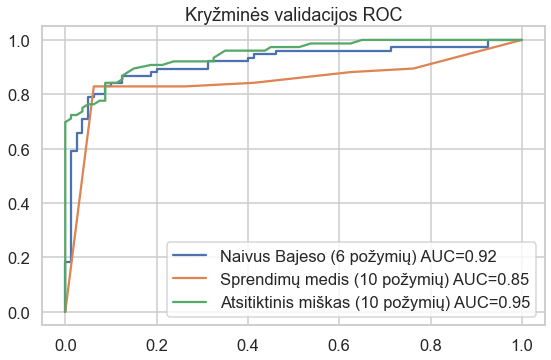

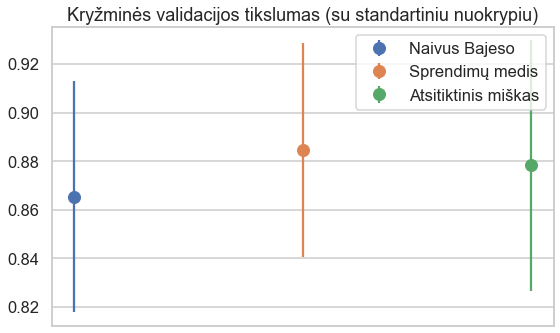

In [90]:
cross_validate_ROC_AUC(X_train,y_train,models,cv)

In [91]:
models = [nb_best,dt_best,rf_best,nb_pca_best,dt_pca_best,rf_pca_best]
names = ["Naivus Bajeso","Sprendimų medis",
         "Atsitiktinis miškas","Naivus Bajeso (PCA)",
         "Sprendimų medis (PCA)","Atsitiktinis miškas (PCA)"]

Naivus Bajeso
              precision    recall  f1-score     support
10s            0.847059  0.900000  0.872727   80.000000
80s            0.887324  0.828947  0.857143   76.000000
accuracy       0.865385  0.865385  0.865385    0.865385
macro avg      0.867191  0.864474  0.864935  156.000000
weighted avg   0.866675  0.865385  0.865135  156.000000


Sprendimų medis
              precision    recall  f1-score     support
10s            0.852273  0.937500  0.892857   80.000000
80s            0.926471  0.828947  0.875000   76.000000
accuracy       0.884615  0.884615  0.884615    0.884615
macro avg      0.889372  0.883224  0.883929  156.000000
weighted avg   0.888420  0.884615  0.884158  156.000000


Atsitiktinis miškas
              precision    recall  f1-score     support
10s            0.858824  0.912500  0.884848   80.000000
80s            0.901408  0.842105  0.870748   76.000000
accuracy       0.878205  0.878205  0.878205    0.878205
macro avg      0.880116  0.877303  0.877798  156.0

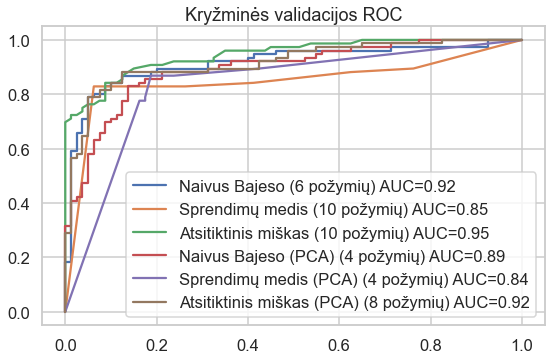

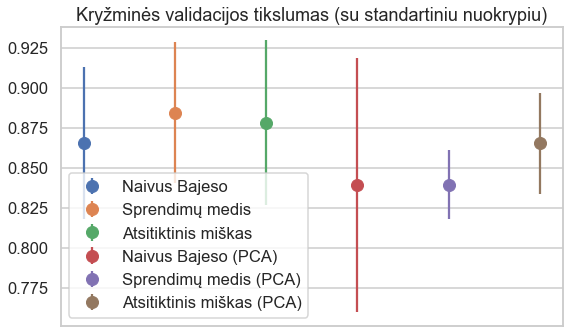

In [92]:
cross_validate_ROC_AUC(X_train,y_train,models,cv)

In [95]:
nb_best_2 = fit_model(X_train,y_train,nb_pipe,validate,param_grid_nb).best_estimator_

dt_best_2 = fit_model(X_train,y_train,dt_pipe,validate,param_grid_dt).best_estimator_

rf_best_2 = fit_model(X_train,y_train,rf_pipe,validate,param_grid_rf).best_estimator_

models_2 = [nb_best_2,dt_best_2,rf_best_2]

  param_select__n_features_to_select  mean_test_score
0                                0.2         0.826087
1                                0.4         0.847826
2                                0.6         0.869565
3                                0.8         0.869565
4                                1.0         0.891304
   param_model__max_depth param_model__min_samples_split  \
0                       4                              2   
1                       4                              2   
2                       4                              2   
3                       4                              5   
4                       4                              5   
5                       4                              5   
6                       4                             10   
7                       4                             10   
8                       4                             10   
9                       4                             15   
10              

Naivus Bajeso
              precision    recall  f1-score    support
10s            0.862069  0.961538  0.909091  26.000000
80s            0.941176  0.800000  0.864865  20.000000
accuracy       0.891304  0.891304  0.891304   0.891304
macro avg      0.901623  0.880769  0.886978  46.000000
weighted avg   0.896464  0.891304  0.889862  46.000000


Sprendimų medis
              precision    recall  f1-score    support
10s            0.880000  0.846154  0.862745  26.000000
80s            0.809524  0.850000  0.829268  20.000000
accuracy       0.847826  0.847826  0.847826   0.847826
macro avg      0.844762  0.848077  0.846007  46.000000
weighted avg   0.849358  0.847826  0.848190  46.000000


Atsitiktinis miškas
              precision    recall  f1-score    support
10s            0.866667  1.000000  0.928571  26.000000
80s            1.000000  0.800000  0.888889  20.000000
accuracy       0.913043  0.913043  0.913043   0.913043
macro avg      0.933333  0.900000  0.908730  46.000000
weighted av

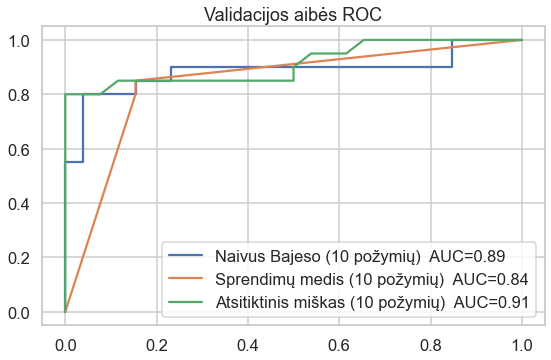

In [96]:
validate_ROC_AUC(X_train,y_train,models_2,validate)

In [97]:
nb_pca_best_2 = fit_model(X_train,y_train,nb_pca_pipe,validate,param_grid_pca_nb).best_estimator_

dt_pca_best_2 = fit_model(X_train,y_train,dt_pca_pipe,validate,param_grid_pca_dt).best_estimator_

rf_pca_best_2 = fit_model(X_train,y_train,rf_pca_pipe,validate,param_grid_pca_rf).best_estimator_

models_2 = [nb_best_2,dt_best_2,rf_best_2,nb_pca_best_2,dt_pca_best_2,rf_pca_best_2]

  param_select__n_components  mean_test_score
0                          2         0.782609
1                          4         0.782609
2                          6         0.782609
3                          8         0.760870
4                         10         0.804348
   param_model__max_depth param_model__min_samples_split  \
0                       4                              2   
1                       4                              2   
2                       4                              2   
3                       4                              2   
4                       4                              5   
5                       4                              5   
6                       4                              5   
7                       4                              5   
8                       4                             10   
9                       4                             10   
10                      4                             10   
11  

Naivus Bajeso
              precision    recall  f1-score    support
10s            0.862069  0.961538  0.909091  26.000000
80s            0.941176  0.800000  0.864865  20.000000
accuracy       0.891304  0.891304  0.891304   0.891304
macro avg      0.901623  0.880769  0.886978  46.000000
weighted avg   0.896464  0.891304  0.889862  46.000000


Sprendimų medis
              precision    recall  f1-score    support
10s            0.880000  0.846154  0.862745  26.000000
80s            0.809524  0.850000  0.829268  20.000000
accuracy       0.847826  0.847826  0.847826   0.847826
macro avg      0.844762  0.848077  0.846007  46.000000
weighted avg   0.849358  0.847826  0.848190  46.000000


Atsitiktinis miškas
              precision    recall  f1-score    support
10s            0.866667  1.000000  0.928571  26.000000
80s            1.000000  0.800000  0.888889  20.000000
accuracy       0.913043  0.913043  0.913043   0.913043
macro avg      0.933333  0.900000  0.908730  46.000000
weighted av

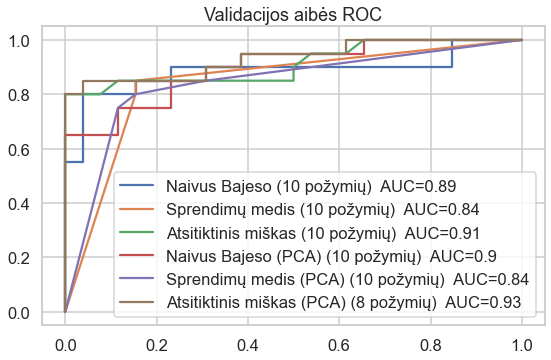

In [99]:
validate_ROC_AUC(X_train,y_train,models_2,validate)

In [98]:
# this is a helper function to paste into a word table
filenames = ['validate_Naivus Bajeso.csv','validate_Sprendimų medis.csv','validate_Atsitiktinis miškas.csv']
filenames2 = ['cross_validate_Naivus Bajeso.csv',
              'cross_validate_Sprendimų medis.csv','cross_validate_Atsitiktinis miškas.csv']

data = pd.concat([pd.read_csv(i) for i in filenames])
data.to_csv("word_table_validate.csv",index=False)


data = pd.concat([pd.read_csv(i) for i in filenames2])
data.to_csv("word_table_cross_validate.csv",index=False)

### Model evaluation

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(2)
pca.fit(X_train)
X_small = pca.transform(X_test)

def metric(model, name, X_test, y_test, X_small, df=df):
    fig, ax = plt.subplots()
    
    y_pred = model.predict(X_test)
    cr = classification_report(y_test,y_pred,output_dict=True)
    cr = pd.DataFrame(cr).transpose()
    print(name)
    print(cr)
    print("\n")
    print("Confusion matrix")
    print(confusion_matrix(y_test,y_pred))
    print("\n")
    
         # this is to convert to a 'writable' format
    cr = cr.reset_index()
    cr = cr.iloc[0:2,:4]
    cr["accuracy"] = accuracy_score(y_test,y_pred)
    cr.columns.values[0] = "klasė"
    cr.insert(0,"modelis",name)
    cr.columns = pd.Series(cr.columns).str.title()
    cr.round(2).to_csv("test_"+ name + ".csv",index=False)
    
    classes = []
    for i,j in zip(y_test,y_pred):
        if i == "80s" and j == "10s":
            classes.append("Tikra 80s, Prog. 10s")
        if i == "80s" and j == "80s":
            classes.append("Tikra 80s, Prog. 80s")
        if i == "10s" and j == "80s":
            classes.append("Tikra 10s, Prog. 80s")
        if i == "10s" and j == "10s":
            classes.append("Tikra 10s, Prog. 10s")   
    classes = pd.Categorical(classes)
    ax = sns.scatterplot(X_small[:,0],X_small[:,1],hue=classes,
                    style=classes,s=75,markers=["o","X","X","o"],
                    palette=["blue","black","purple","red"],ax=ax)
    ax.set_title("Testavimo aibės rezultatai " +  "(" + name + ")")
    print("Blogai klasifikuotos dainos:")
    print(df.iloc[indices_test].iloc[(y_pred != y_test),1:4])
    print("\n\n")

In [ ]:
for i,j in zip(models,names):
    metric(i,j,X_test,y_test,X_small)

In [ ]:
filenames3 = ['test_Naivus Bajeso.csv',
              'test_Sprendimų medis.csv','test_Atsitiktinis miškas.csv']

data = pd.concat([pd.read_csv(i) for i in filenames3])
data.to_csv("word_table_test.csv",index=False)